In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import collections
import functools
import itertools
import os
import pathlib
import re
import textwrap

import matplotlib.pyplot as plt
import numpy as np
import datasets
import shutil
import tensorflow as tf
import transformers
import tqdm

comet_ml is installed but `COMET_API_KEY` is not set.
/usr/local/google/home/julesgm/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Prepare different HuggingFace objects that will definitely be needed.

kilt = datasets.load_dataset("kilt_tasks")
eli5 = {k.split("_")[0]: v for k, v in kilt.items() if "eli5" in k}
tokenizer = transformers.GPT2TokenizerFast.from_pretrained("gpt2-xl")
print(f"Dataset split keys: {list(eli5.keys())}")

Reusing dataset kilt_tasks (/usr/local/google/home/julesgm/.cache/huggingface/datasets/kilt_tasks/all_tasks/1.0.0/821c4295a2c35db2847585918d9c47d7f028f1a26b78825d8e77cd3aeb2621a1)


Dataset split keys: ['train', 'validation', 'test']


In [4]:
# Extract the lengths of combined question and answer text, once tokenized with the GPT2 tokenizer.

def get_len(sample):
    question = sample["input"].strip()
    answer = min(sample["output"]["answer"], key=len).strip()
    len_ = len(tokenizer(question + " " + answer)["input_ids"])

    return {"len_":len_}
mapped = eli5["train"].map(get_len, num_proc=os.cpu_count())

In [5]:
# Count the number of entries of each length, then sort by length

counts = collections.Counter(mapped["len_"])
sorted_counts = sorted(counts.items(), key=lambda x: x[0])

In [7]:
# Compute the ratio of samples that are in a certain percentile of lengths, and compute how long retrievals
# would have to be for a certain fraction of the dataset to have access to that amount of retrievals

context_length = 1024
max_num_retrievals = 4
fractions = [.55, .6, .65, .7, .75, .775, .8, .825, .85, .875, .9, .925, .95, .975][::-1]

points = {}
max_pairs = {}
for top_fraction in fractions:
    qty_accumulator = 0
    cumulative = [
        (count, qty_accumulator := qty / len(eli5["train"]) + qty_accumulator) 
        for count, qty in sorted_counts if qty_accumulator < top_fraction
    ]
    x = [x[0] for x in cumulative]
    y = [x[1] for x in cumulative]
    points[top_fraction] = (x, y)
    max_pair = max(cumulative, key=lambda pair: pair[1])
    max_pairs[top_fraction] = max_pair[0]
    print(f"{top_fraction:0.1%}: {max_pair[0]} bpe tokens or fewer")
    for i in range(1, max_num_retrievals + 1):
        print(f"({context_length} - {max_pair[0]}) / {i} = {(context_length - max_pair[0]) / i:0.0f}")


97.5%: 398 bpe tokens or fewer
(1024 - 398) / 1 = 626
(1024 - 398) / 2 = 313
(1024 - 398) / 3 = 209
(1024 - 398) / 4 = 156
95.0%: 295 bpe tokens or fewer
(1024 - 295) / 1 = 729
(1024 - 295) / 2 = 364
(1024 - 295) / 3 = 243
(1024 - 295) / 4 = 182
92.5%: 244 bpe tokens or fewer
(1024 - 244) / 1 = 780
(1024 - 244) / 2 = 390
(1024 - 244) / 3 = 260
(1024 - 244) / 4 = 195
90.0%: 211 bpe tokens or fewer
(1024 - 211) / 1 = 813
(1024 - 211) / 2 = 406
(1024 - 211) / 3 = 271
(1024 - 211) / 4 = 203
87.5%: 187 bpe tokens or fewer
(1024 - 187) / 1 = 837
(1024 - 187) / 2 = 418
(1024 - 187) / 3 = 279
(1024 - 187) / 4 = 209
85.0%: 169 bpe tokens or fewer
(1024 - 169) / 1 = 855
(1024 - 169) / 2 = 428
(1024 - 169) / 3 = 285
(1024 - 169) / 4 = 214
82.5%: 154 bpe tokens or fewer
(1024 - 154) / 1 = 870
(1024 - 154) / 2 = 435
(1024 - 154) / 3 = 290
(1024 - 154) / 4 = 218
80.0%: 142 bpe tokens or fewer
(1024 - 142) / 1 = 882
(1024 - 142) / 2 = 441
(1024 - 142) / 3 = 294
(1024 - 142) / 4 = 220
77.5%: 132 bpe t

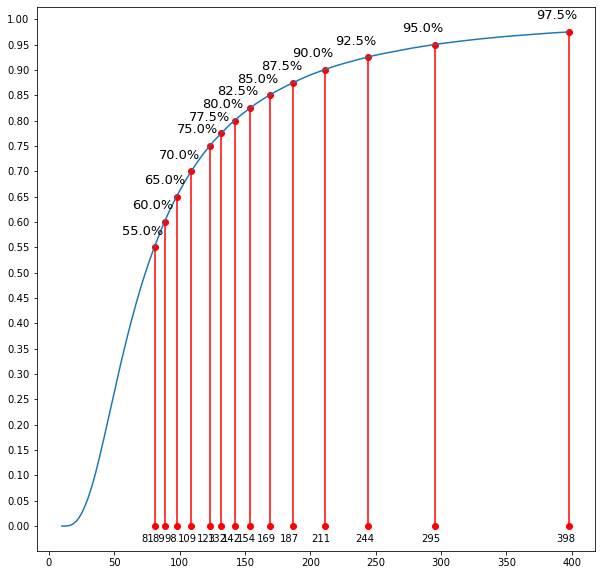

In [8]:
# Graph the results.

plt.figure(figsize=(10, 10));
ax = plt.gca()
ax.margins(tight=True)
ax.plot(*points[max(fractions)]);
plt.yticks(np.linspace(0, 1, 21))
percentages = max_pairs.keys()
lengths = max_pairs.values()

for x, y in zip(lengths, percentages):
    ax.plot((x, x), (0, y), color="red")

ax.scatter(lengths, 
           percentages, color="red");
ax.scatter(lengths, 
           [0 for _ in lengths], color="red");

for y, x in max_pairs.items():
    ax.text(x - 25, y + 0.025, f"{y:0.1%}", size=13)
    ax.text(x - 10, -0.032, f"{x}", size=10)